In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("DS203_YouTube_Project") \
    .getOrCreate()


In [7]:
spark


In [8]:
base_path = r"C:\Users\Admin\Downloads\youtube10"


In [9]:
# define a mapping

files = {
    "USA": "USvideos.csv",
    "Great Britain": "GBvideos.csv",
    "Germany": "DEvideos.csv",
    "Canada": "CAvideos.csv",
    "Russia": "RUvideos.csv",
    "Mexico": "MXvideos.csv",
    "South Korea": "KRvideos.csv",
    "Japan": "JPvideos.csv",
    "India": "INvideos.csv",
    "France": "FRvideos.csv"
}


In [10]:
# load, clean,and add country column

from pyspark.sql.functions import col, lit

dfs = []

for country, filename in files.items():
    df = spark.read.csv(
        base_path + "\\" + filename,
        header=True,
        quote='"',
        escape='"',
        multiLine=True,
        mode="PERMISSIVE"
    )
    
    df = (
        df.dropna(how="all")
          .withColumn("views", col("views").cast("long"))
          .withColumn("likes", col("likes").cast("long"))
          .withColumn("dislikes", col("dislikes").cast("long"))
          .withColumn("comment_count", col("comment_count").cast("long"))
          .fillna({"views":0, "likes":0, "dislikes":0, "comment_count":0})
          .dropDuplicates(["video_id","trending_date"])
          .withColumn("country", lit(country))  
    )
    
    dfs.append(df)


In [11]:
# union all datasets

youtube = dfs[0]
for df in dfs[1:]:
    youtube = youtube.unionByName(df)

youtube.cache()

DataFrame[video_id: string, trending_date: string, title: string, channel_title: string, category_id: string, publish_time: string, tags: string, views: bigint, likes: bigint, dislikes: bigint, comment_count: bigint, thumbnail_link: string, comments_disabled: string, ratings_disabled: string, video_error_or_removed: string, description: string, country: string]

In [12]:
youtube.count()

361424

In [13]:
youtube.select("country").distinct().show()


+-------------+
|      country|
+-------------+
|          USA|
|Great Britain|
|      Germany|
|       Canada|
|       Russia|
|       Mexico|
|  South Korea|
|        Japan|
|        India|
|       France|
+-------------+



In [14]:
youtube.createOrReplaceTempView("youtube")

In [15]:
rows = youtube.count()
cols = len(youtube.columns)
print("Rows:", rows)
print("Columns:", cols)


Rows: 361424
Columns: 17


In [29]:
# datasets descritption

youtube.select(
    "views", "likes", "dislikes", "comment_count"
).describe().show()


+-------+------------------+------------------+------------------+------------------+
|summary|             views|             likes|          dislikes|     comment_count|
+-------+------------------+------------------+------------------+------------------+
|  count|            361424|            361424|            361424|            361424|
|   mean|1343658.9433822879| 38365.42199466554|2158.0683380185046| 4300.458718845456|
| stddev|7205986.3231959725|166164.88463084307|22897.645647235084|25454.166503819444|
|    min|               117|                 0|                 0|                 0|
|    max|         424538912|           5613827|           1944971|           1626501|
+-------+------------------+------------------+------------------+------------------+



In [30]:
# Filtering 1: Videos with over 1 million views

spark.sql("""
SELECT country, title, views
FROM youtube
WHERE views > 1000000
ORDER BY views DESC
LIMIT 10
""").show(truncate=False)


+-------------+---------------------------------------------------------------------------------------+---------+
|country      |title                                                                                  |views    |
+-------------+---------------------------------------------------------------------------------------+---------+
|Great Britain|Nicky Jam x J. Balvin - X (EQUIS) | Video Oficial | Prod. Afro Bros & Jeon             |424538912|
|Great Britain|Nicky Jam x J. Balvin - X (EQUIS) | Video Oficial | Prod. Afro Bros & Jeon             |413586699|
|Great Britain|Nicky Jam x J. Balvin - X (EQUIS) | Video Oficial | Prod. Afro Bros & Jeon             |402650804|
|Great Britain|Nicky Jam x J. Balvin - X (EQUIS) | Video Oficial | Prod. Afro Bros & Jeon             |392036878|
|Great Britain|Nicky Jam x J. Balvin - X (EQUIS) | Video Oficial | Prod. Afro Bros & Jeon             |382401497|
|Great Britain|Nicky Jam x J. Balvin - X (EQUIS) | Video Oficial | Prod. Afro Bros & Jeo

In [31]:
# Filtering 2:Canada videos with comments disabled

spark.sql("""
SELECT country, title, comments_disabled
FROM youtube
WHERE country='Canada' AND comments_disabled=true
LIMIT 10
""").show(truncate=False)


+-------+--------------------------------------------------------------------------------------------------+-----------------+
|country|title                                                                                             |comments_disabled|
+-------+--------------------------------------------------------------------------------------------------+-----------------+
|Canada |The National for Thursday February 15, 2018 - Shooting Vigil, Olympics, Indigenous Rights         |True             |
|Canada |Justin Timberlake Surprises Super Bowl Selfie Kid Ryan McKenna                                    |True             |
|Canada |Ponderosa - Juror #6                                                                              |True             |
|Canada |2018 Minnesota State High School All Hockey Hair Team                                             |True             |
|Canada |Keynote (Google I/O '18)                                                                          |Tru

In [32]:
# Filtering 3:India videos with high views AND high likes
spark.sql("""
SELECT country, title, views, likes
FROM youtube
WHERE country='India' AND views > 500000 AND likes > 20000
ORDER BY likes DESC
LIMIT 10
""").show(truncate=False)

+-------+-------------------------------------------------------+---------+-------+
|country|title                                                  |views    |likes  |
+-------+-------------------------------------------------------+---------+-------+
|India  |YouTube Rewind: The Shape of 2017 | #YouTubeRewind     |125432237|2912710|
|India  |YouTube Rewind: The Shape of 2017 | #YouTubeRewind     |113876217|2811216|
|India  |YouTube Rewind: The Shape of 2017 | #YouTubeRewind     |100911567|2656672|
|India  |Marvel Studios' Avengers: Infinity War Official Trailer|89930713 |2606663|
|India  |Marvel Studios' Avengers: Infinity War Official Trailer|87449453 |2584674|
|India  |Marvel Studios' Avengers: Infinity War Official Trailer|84281319 |2555411|
|India  |Marvel Studios' Avengers: Infinity War Official Trailer|80360459 |2513102|
|India  |Marvel Studios' Avengers: Infinity War Official Trailer|74789251 |2444956|
|India  |Marvel Studios' Avengers: Infinity War Official Trailer|66637636 |2

In [33]:
# Filtering 4:Music OR Entertainment category

spark.sql("""
SELECT country, title, category_id
FROM youtube
WHERE category_id IN (10, 24)
LIMIT 10
""").show(truncate=False)


+-------+-------------------------------------------------------------------------------------+-----------+
|country|title                                                                                |category_id|
+-------+-------------------------------------------------------------------------------------+-----------+
|USA    |Will It Christmas Tree?                                                              |24         |
|USA    |100 Years of Eyes | Allure                                                           |24         |
|USA    |Cardi B: 2018 iHeartRadio Music Awards | Acceptance Speech | TBS                     |24         |
|USA    |Amy Schumer Shares Her Experience with Gray-Area Rape | SuperSoul Conversations | OWN|24         |
|USA    |Lin-Manuel Miranda & Ben Platt Found Tonight [Official Video]                        |10         |
|USA    |SMALLFOOT - Official Trailer 1                                                       |24         |
|USA    |Portugal. The Man -

In [34]:
# Filtering 5:Removed/Error videos

spark.sql("""
SELECT country, title
FROM youtube
WHERE video_error_or_removed = true
LIMIT 10
""").show(truncate=False)


+-------+-------------------------------------------------------------+
|country|title                                                        |
+-------+-------------------------------------------------------------+
|USA    |Earth Day 2018 Google Doodle                                 |
|USA    |Cobra Kai Ep 2 - Strike First - The Karate Kid Saga Continues|
|USA    |Earth Day 2018 Google Doodle                                 |
|USA    |Cobra Kai Ep 2 - Strike First - The Karate Kid Saga Continues|
|USA    |Earth Day 2018 Google Doodle                                 |
|USA    |Cobra Kai Ep 2 - Strike First - The Karate Kid Saga Continues|
|USA    |Deleted video                                                |
|USA    |Cobra Kai Ep 2 - Strike First - The Karate Kid Saga Continues|
|USA    |Earth Day 2018 Google Doodle                                 |
|USA    |Earth Day 2018 Google Doodle                                 |
+-------+-------------------------------------------------------

In [36]:
# Aggregate 1: Average & max views per country

spark.sql("""
SELECT country,
       ROUND(AVG(views),2) AS avg_views,
       MAX(views) AS max_views
FROM youtube
GROUP BY country
ORDER BY avg_views DESC
""").show()


+-------------+----------+---------+
|      country| avg_views|max_views|
+-------------+----------+---------+
|Great Britain|5911516.03|424538912|
|          USA|2360648.79|225211923|
|       Canada|1147035.91|137843120|
|        India| 961130.26|125432237|
|      Germany| 603455.32|113876217|
|       France| 419921.85|100911567|
|  South Korea| 419652.34|113876217|
|       Mexico| 341601.11|100912384|
|       Russia| 239623.61| 62796390|
|        Japan| 238498.77| 62796390|
+-------------+----------+---------+



In [16]:
# Aggregate 2: Total views per country

spark.sql("""
SELECT country,
       SUM(views) AS total_views
FROM youtube
GROUP BY country
ORDER BY total_views DESC
""").show()


+-------------+------------+
|      country| total_views|
+-------------+------------+
|Great Britain|229023953981|
|          USA| 96548174987|
|       Canada| 46891975069|
|        India| 31196671671|
|      Germany| 24645115205|
|       France| 17100897444|
|       Mexico| 13689027981|
|  South Korea| 13404535053|
|       Russia|  9662103354|
|        Japan|  3468487653|
+-------------+------------+



In [17]:
# Group by country & category

spark.sql("""
SELECT country, category_id, COUNT(*) AS video_count
FROM youtube
GROUP BY country, category_id
ORDER BY video_count DESC
LIMIT 20
""").show()


+-------------+-----------+-----------+
|      country|category_id|video_count|
+-------------+-----------+-----------+
|      Germany|         24|      15292|
|        India|         24|      14511|
|Great Britain|         10|      13698|
|       Canada|         24|      13451|
|       Mexico|         24|      13361|
|       Russia|         22|      10244|
|          USA|         24|       9943|
|       France|         24|       9819|
|Great Britain|         24|       9055|
|  South Korea|         24|       8306|
|       Mexico|         22|       8070|
|  South Korea|         25|       6896|
|  South Korea|         22|       6601|
|          USA|         10|       6467|
|      Germany|         22|       5988|
|       Russia|         24|       5886|
|       France|         22|       5719|
|       Russia|         25|       5353|
|        India|         25|       4649|
|        Japan|         24|       4359|
+-------------+-----------+-----------+



In [18]:
# Sorting: Top videos by views

spark.sql("""
SELECT country, title, views
FROM youtube
ORDER BY views DESC
LIMIT 10
""").show(truncate=False)


+-------------+---------------------------------------------------------------------------------------+---------+
|country      |title                                                                                  |views    |
+-------------+---------------------------------------------------------------------------------------+---------+
|Great Britain|Nicky Jam x J. Balvin - X (EQUIS) | Video Oficial | Prod. Afro Bros & Jeon             |424538912|
|Great Britain|Nicky Jam x J. Balvin - X (EQUIS) | Video Oficial | Prod. Afro Bros & Jeon             |413586699|
|Great Britain|Nicky Jam x J. Balvin - X (EQUIS) | Video Oficial | Prod. Afro Bros & Jeon             |402650804|
|Great Britain|Nicky Jam x J. Balvin - X (EQUIS) | Video Oficial | Prod. Afro Bros & Jeon             |392036878|
|Great Britain|Nicky Jam x J. Balvin - X (EQUIS) | Video Oficial | Prod. Afro Bros & Jeon             |382401497|
|Great Britain|Nicky Jam x J. Balvin - X (EQUIS) | Video Oficial | Prod. Afro Bros & Jeo

In [20]:
# Create country summary

country_summary = spark.sql("""
SELECT country,
       AVG(views) AS avg_views_country,
       SUM(views) AS total_views_country
FROM youtube
GROUP BY country
""")

country_summary.createOrReplaceTempView("country_summary")


In [21]:
# LEFT JOIN

spark.sql("""
SELECT y.country, y.title, y.views, c.avg_views_country
FROM youtube y
LEFT JOIN country_summary c
ON y.country = c.country
LIMIT 10
""").show(truncate=False)


+-------+-------------------------------------------------------------------------------------+--------+-----------------+
|country|title                                                                                |views   |avg_views_country|
+-------+-------------------------------------------------------------------------------------+--------+-----------------+
|USA    |Why Atlantic fish are invading the Arctic                                            |309873  |2360648.793051175|
|USA    |Will It Christmas Tree?                                                              |497085  |2360648.793051175|
|USA    |Multiple Casualties And Injuries Reported As Amtrak Train Derails Near Seattle | TIME|1321517 |2360648.793051175|
|USA    |Honest workout routine                                                               |124216  |2360648.793051175|
|USA    |THE GREEN MAKEUP CHALLENGE! | NikkieTutorials                                        |2822782 |2360648.793051175|
|USA    |100 Yea

In [22]:
# Window 1: Top 3 videos per country

spark.sql("""
SELECT *
FROM (
    SELECT country, title, views,
           DENSE_RANK() OVER (PARTITION BY country ORDER BY views DESC) AS rank
    FROM youtube
)
WHERE rank <= 3
ORDER BY country, rank
""").show(truncate=False)


+-------------+--------------------------------------------------------------------------+---------+----+
|country      |title                                                                     |views    |rank|
+-------------+--------------------------------------------------------------------------+---------+----+
|Canada       |YouTube Rewind: The Shape of 2017 | #YouTubeRewind                        |137843120|1   |
|Canada       |YouTube Rewind: The Shape of 2017 | #YouTubeRewind                        |125431369|2   |
|Canada       |YouTube Rewind: The Shape of 2017 | #YouTubeRewind                        |113876217|3   |
|France       |YouTube Rewind: The Shape of 2017 | #YouTubeRewind                        |100911567|1   |
|France       |YouTube Rewind: The Shape of 2017 | #YouTubeRewind                        |75969469 |2   |
|France       |BTS (방탄소년단) 'FAKE LOVE' Official MV                                  |65396157 |3   |
|Germany      |YouTube Rewind: The Shape of 2017 | 

In [23]:
# Window 2: Previous views using LAG

spark.sql("""
SELECT country, title, views,
       LAG(views, 1) OVER (PARTITION BY country ORDER BY views DESC) AS prev_views
FROM youtube
LIMIT 20
""").show(truncate=False)


+-------+----------------------------------------------------------------------------+--------+----------+
|country|title                                                                       |views   |prev_views|
+-------+----------------------------------------------------------------------------+--------+----------+
|Russia |BTS (방탄소년단) 'FAKE LOVE' Official MV                                    |62796390|NULL      |
|Russia |YouTube Rewind: The Shape of 2017 | #YouTubeRewind                          |52611730|62796390  |
|Russia |BTS (방탄소년단) 'FAKE LOVE' Official MV                                    |39349927|52611730  |
|Russia |To Our Daughter                                                             |35832484|39349927  |
|Russia |Childish Gambino - This Is America (Official Video)                         |31648454|35832484  |
|Russia |VENOM - Official Trailer (HD)                                               |27973210|31648454  |
|Russia |YouTube Rewind: The Shape of 2017 | #Y

In [24]:
# Running total

spark.sql("""
SELECT country, title, views,
       SUM(views) OVER (
           PARTITION BY country
           ORDER BY views DESC
           ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
       ) AS running_total_views
FROM youtube
LIMIT 20
""").show(truncate=False)


+-------+----------------------------------------------------------------------------+--------+-------------------+
|country|title                                                                       |views   |running_total_views|
+-------+----------------------------------------------------------------------------+--------+-------------------+
|Russia |BTS (방탄소년단) 'FAKE LOVE' Official MV                                    |62796390|62796390           |
|Russia |YouTube Rewind: The Shape of 2017 | #YouTubeRewind                          |52611730|115408120          |
|Russia |BTS (방탄소년단) 'FAKE LOVE' Official MV                                    |39349927|154758047          |
|Russia |To Our Daughter                                                             |35832484|190590531          |
|Russia |Childish Gambino - This Is America (Official Video)                         |31648454|222238985          |
|Russia |VENOM - Official Trailer (HD)                                            

In [25]:
# Running average

spark.sql("""
SELECT country, title, views,
       AVG(views) OVER (
           PARTITION BY country
           ORDER BY views DESC
           ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
       ) AS running_avg_views
FROM youtube
LIMIT 20
""").show(truncate=False)


+-------+----------------------------------------------------------------------------+--------+--------------------+
|country|title                                                                       |views   |running_avg_views   |
+-------+----------------------------------------------------------------------------+--------+--------------------+
|Russia |BTS (방탄소년단) 'FAKE LOVE' Official MV                                    |62796390|6.279639E7          |
|Russia |YouTube Rewind: The Shape of 2017 | #YouTubeRewind                          |52611730|5.770406E7          |
|Russia |BTS (방탄소년단) 'FAKE LOVE' Official MV                                    |39349927|5.1586015666666664E7|
|Russia |To Our Daughter                                                             |35832484|4.764763275E7       |
|Russia |Childish Gambino - This Is America (Official Video)                         |31648454|4.4447797E7         |
|Russia |VENOM - Official Trailer (HD)                                    

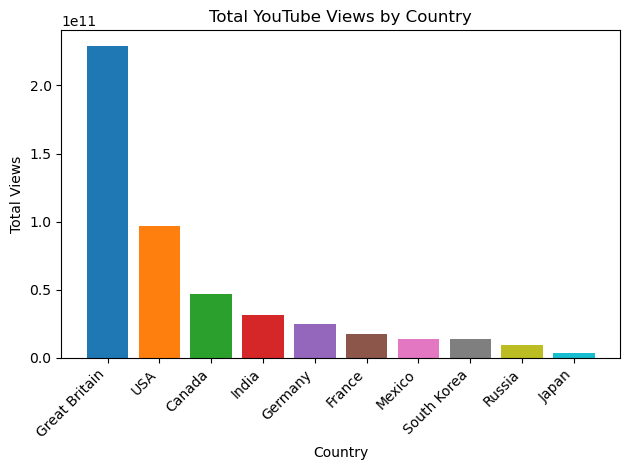

In [27]:
import matplotlib.pyplot as plt

# Aggregate total views by country
country_views_pd = (
    youtube.groupBy("country")
           .sum("views")
           .withColumnRenamed("sum(views)", "total_views")
           .orderBy("total_views", ascending=False)
           .toPandas()
)

# Explicit colors for each country (as requested)
colors = [
    "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple",
    "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"
]

plt.figure()
plt.bar(
    country_views_pd["country"],
    country_views_pd["total_views"],
    color=colors
)

plt.xticks(rotation=45, ha="right")
plt.title("Total YouTube Views by Country")
plt.xlabel("Country")
plt.ylabel("Total Views")
plt.tight_layout()
plt.show()


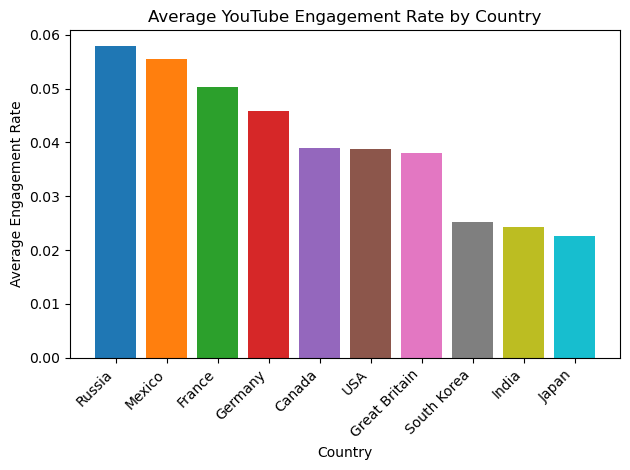

In [28]:
import matplotlib.pyplot as plt

# Calculate engagement rate and average per country
engagement_pd = (
    youtube.withColumn(
        "engagement_rate",
        (youtube.likes + youtube.comment_count) / (youtube.views + 1)
    )
    .groupBy("country")
    .avg("engagement_rate")
    .withColumnRenamed("avg(engagement_rate)", "avg_engagement_rate")
    .orderBy("avg_engagement_rate", ascending=False)
    .toPandas()
)

# One distinct color per country (10 countries)
colors = [
    "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple",
    "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"
]

plt.figure()
plt.bar(
    engagement_pd["country"],
    engagement_pd["avg_engagement_rate"],
    color=colors
)
plt.xticks(rotation=45, ha="right")
plt.title("Average YouTube Engagement Rate by Country")
plt.xlabel("Country")
plt.ylabel("Average Engagement Rate")
plt.tight_layout()
plt.show()


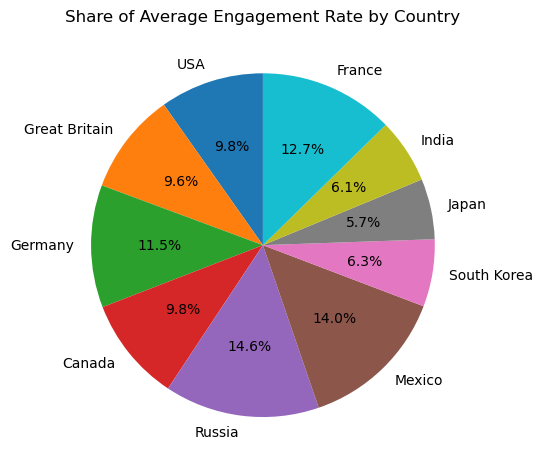

In [30]:
# Compute engagement rate and average per country
engagement_pd = (
    youtube.withColumn(
        "engagement_rate",
        (youtube.likes + youtube.comment_count) / (youtube.views + 1)
    )
    .groupBy("country")
    .avg("engagement_rate")
    .withColumnRenamed("avg(engagement_rate)", "avg_engagement_rate")
    .toPandas()
)

plt.figure()
plt.pie(
    engagement_pd["avg_engagement_rate"],
    labels=engagement_pd["country"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Share of Average Engagement Rate by Country")
plt.tight_layout()
plt.show()
